
**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [695]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image, ImageChops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [696]:
cpu_count = mp.cpu_count()
print(cpu_count)

16


## 1. Make train-test split

**Data Link**: https://www.kaggle.com/shawon10/captcha-recognition

In [697]:
data_path = "./output"

In [698]:
image_fns = os.listdir(data_path)
image_fns = [f"{i}.png" for i in range(len(image_fns))]
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

10644
[1 2 3 4 5]


In [699]:
# image_fns.remove('samples')
print(len(image_fns))

10644


In [700]:
label = pd.read_csv('./data2.csv')

In [701]:
label

,label
0,59422
1,15322
2,100042
3,188280
4,328376
...,...
10639,x
10640,x
10641,x
10642,x


In [702]:
data = train_test_split(image_fns, list(map(str, label['label'].to_numpy())), random_state=0)
image_fns_train, image_fns_test, label_train, label_test = data[0], data[1], data[2], data[3]
# data = train_test_split(image_fns, label['label'].to_numpy(), random_state=0)
# print(data)
print(len(image_fns_train), len(image_fns_test))

7983 2661


## 2. Define character maps

In [703]:
image_ns = [str(num) for num in label['label']]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

11
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'x']


In [704]:
vocabulary = ['-'] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

12
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'x']
{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'x'}
{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'x': 11}


## 3. Define data loader

In [705]:
batch_size = 64

In [706]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns, label):
        self.data_dir = data_dir
        self.image_fns = image_fns
        self.label = label
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        noise = Image.effect_noise((200, 50), 100).convert('RGB')
        image = ImageChops.multiply(image, noise)
        image = self.transform(image)
        text = self.label[index]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [707]:
trainset = CAPTCHADataset(data_path, image_fns_train, label_train) 
testset = CAPTCHADataset(data_path, image_fns_test, label_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False)
print(len(train_loader), len(test_loader))

125 42


In [708]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([64, 3, 50, 200]) ('258409', '4598', '229844', '13746', '1127093', '706296', '3286', '1074617', '1265400', '317059', '919225', '18831', '574218', '31886', '1207504', '191259', '1258236', 'x', '618816', 'x', '259516', '282558', '1484922', '636883', '16022', '51479', '85430', '1005184', '148742', '948062', '1052128', '29894', '1311250', '105805', '185719', '1014462', 'x', '5267', '1726', '633184', '140208', 'x', '57927', '197872', '102132', '70157', '110649', '898166', '12417', '230612', '142953', '2879', '1561', '20913', '247077', '1225', 'x', 'x', '648436', '45699', '1181', '1415', '506852', '481425')


## 4. Define model

In [709]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

12


In [710]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [711]:
resnet = resnet18(pretrained=False)
#print(resnet)

In [712]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [713]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [714]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [715]:
#crnn

In [716]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('258409', '4598', '229844', '13746', '1127093', '706296', '3286', '1074617', '1265400', '317059', '919225', '18831', '574218', '31886', '1207504', '191259', '1258236', 'x', '618816', 'x', '259516', '282558', '1484922', '636883', '16022', '51479', '85430', '1005184', '148742', '948062', '1052128', '29894', '1311250', '105805', '185719', '1014462', 'x', '5267', '1726', '633184', '140208', 'x', '57927', '197872', '102132', '70157', '110649', '898166', '12417', '230612', '142953', '2879', '1561', '20913', '247077', '1225', 'x', 'x', '648436', '45699', '1181', '1415', '506852', '481425')
torch.Size([10, 64, 12])


## 5. Define loss

In [717]:
criterion = nn.CTCLoss(blank=0)

In [718]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [719]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [720]:
compute_loss(text_batch, text_batch_logits)

tensor(4.8460, device='cuda:0', grad_fn=<MeanBackward0>)

## 6. Train model

In [721]:
num_epochs = 200
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [722]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [723]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [724]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:1    Loss:1.267627417564392    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:2    Loss:0.6208342847824097    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:3    Loss:0.5177559385299683    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:4    Loss:0.47738217520713805    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:5    Loss:0.5541664927005768    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:6    Loss:0.4429881463050842    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:7    Loss:0.43199317693710326    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:8    Loss:0.42646110558509825    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:9    Loss:0.43794130539894105    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:10    Loss:0.4065400514602661    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:11    Loss:0.40794083499908446    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:12    Loss:0.3980629007816315    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:13    Loss:0.3933950147628784    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:14    Loss:0.3914768543243408    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:15    Loss:0.40374900698661803    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:16    Loss:0.3833171799182892    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:17    Loss:0.5143016119003296    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:18    Loss:0.49997052001953124    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:19    Loss:0.4130544776916504    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:20    Loss:0.3984447762966156    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:21    Loss:0.39161785078048705    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:22    Loss:0.38727018642425537    NumUpdates:125
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:23    Loss:0.3544567663669586    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:24    Loss:0.3447753486633301    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:25    Loss:0.3411599214076996    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:26    Loss:0.3387624113559723    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:27    Loss:0.33671933245658875    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:28    Loss:0.33490921807289126    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:29    Loss:0.333800883769989    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:30    Loss:0.3325962190628052    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:31    Loss:0.33123005390167237    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:32    Loss:0.3309587523937225    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:33    Loss:0.3302989509105682    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:34    Loss:0.3294152088165283    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:35    Loss:0.32794074892997743    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:36    Loss:0.32822010135650637    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:37    Loss:0.3268097674846649    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:38    Loss:0.3262996850013733    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:39    Loss:0.3255429034233093    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:40    Loss:0.3253531711101532    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:41    Loss:0.3238880753517151    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:42    Loss:0.32312360787391664    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:43    Loss:0.3227903687953949    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:44    Loss:0.32229556918144225    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:45    Loss:0.3221653776168823    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:46    Loss:0.32170337438583374    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:47    Loss:0.32074043989181517    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:48    Loss:0.3197446527481079    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:49    Loss:0.3201249520778656    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:50    Loss:0.3193416728973389    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:51    Loss:0.3191622157096863    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:52    Loss:0.3189660694599152    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:53    Loss:0.3175581316947937    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:54    Loss:0.3178688468933105    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:55    Loss:0.3177037200927734    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:56    Loss:0.3167690110206604    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:57    Loss:0.31699776220321657    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:58    Loss:0.31623663854599    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:59    Loss:0.31559819960594176    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:60    Loss:0.31560337591171267    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:61    Loss:0.3155261971950531    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:62    Loss:0.3157176394462585    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:63    Loss:0.3145821087360382    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:64    Loss:0.31478364539146425    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:65    Loss:0.31431415820121766    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:66    Loss:0.31419450092315676    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:67    Loss:0.31371150302886963    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:68    Loss:0.31320901799201967    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:69    Loss:0.31401486229896547    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:70    Loss:0.31323702335357667    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:71    Loss:0.3133296754360199    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:72    Loss:0.3132060213088989    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:73    Loss:0.3124553275108337    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:74    Loss:0.31316777276992797    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:75    Loss:0.3128671500682831    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:76    Loss:0.31176713490486146    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:77    Loss:0.31172481036186217    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:78    Loss:0.31147747802734377    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:79    Loss:0.311369167804718    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:80    Loss:0.311525817155838    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:81    Loss:0.31123987436294553    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:82    Loss:0.3113302309513092    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:83    Loss:0.3105503253936768    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:84    Loss:0.31040402603149414    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:85    Loss:0.3105889880657196    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:86    Loss:0.30970696449279783    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:87    Loss:0.3098650650978088    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:88    Loss:0.30941083693504334    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:89    Loss:0.3096077628135681    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:90    Loss:0.3099310250282288    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:91    Loss:0.31013810229301453    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:92    Loss:0.308879780292511    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:93    Loss:0.3091473095417023    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:94    Loss:0.30926120471954344    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:95    Loss:0.3092863042354584    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:96    Loss:0.3085802321434021    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:97    Loss:0.30836898255348205    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:98    Loss:0.3082815387248993    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:99    Loss:0.3082940833568573    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:100    Loss:0.3079249289035797    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:101    Loss:0.30820444107055667    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:102    Loss:0.3079123413562775    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:103    Loss:0.30795349383354187    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:104    Loss:0.3079528558254242    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:105    Loss:0.30807737588882445    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:106    Loss:0.3069876141548157    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:107    Loss:0.30733043456077574    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:108    Loss:0.30713453698158266    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:109    Loss:0.30677815413475035    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:110    Loss:0.30706106519699095    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:111    Loss:0.30721195197105405    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:112    Loss:0.306995112657547    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:113    Loss:0.3071184363365173    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:114    Loss:0.30676307129859925    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:115    Loss:0.30628163838386535    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:116    Loss:0.3061176388263702    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:117    Loss:0.3062023916244507    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:118    Loss:0.30669647407531736    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:119    Loss:0.30606872391700746    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:120    Loss:0.3061757831573486    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:121    Loss:0.30639575481414794    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:122    Loss:0.30614852952957156    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:123    Loss:0.30538341927528384    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:124    Loss:0.3058603322505951    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:125    Loss:0.3055187284946442    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:126    Loss:0.3051157376766205    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:127    Loss:0.30522956132888795    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:128    Loss:0.3053118896484375    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:129    Loss:0.3054417474269867    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:130    Loss:0.3048183009624481    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:131    Loss:0.305035897731781    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:132    Loss:0.3051681332588196    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:133    Loss:0.3053828456401825    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:134    Loss:0.30526000356674193    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:135    Loss:0.3042411930561066    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:136    Loss:0.3039238173961639    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:137    Loss:0.30440883660316465    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:138    Loss:0.30491834568977355    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:139    Loss:0.3042120192050934    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:140    Loss:0.3044476175308228    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:141    Loss:0.3042490789890289    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:142    Loss:0.304374311208725    NumUpdates:125
Epoch   142: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:143    Loss:0.2958717586994171    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:144    Loss:0.2937662470340729    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:145    Loss:0.29326372838020326    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:146    Loss:0.29279906034469605    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:147    Loss:0.2927000529766083    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:148    Loss:0.2925076503753662    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:149    Loss:0.29242609333992003    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:150    Loss:0.2923056354522705    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:151    Loss:0.2921915531158447    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:152    Loss:0.2921766073703766    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:153    Loss:0.29218012404441834    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:154    Loss:0.29193616890907287    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:155    Loss:0.2919921998977661    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:156    Loss:0.29189693117141724    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:157    Loss:0.2919019732475281    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:158    Loss:0.29173307204246524    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:159    Loss:0.2916848702430725    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:160    Loss:0.2916016392707825    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:161    Loss:0.291513872385025    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:162    Loss:0.29151263856887816    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:163    Loss:0.29148539686203    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:164    Loss:0.29161575388908384    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:165    Loss:0.2913589181900024    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:166    Loss:0.29121789741516113    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:167    Loss:0.29125563764572143    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:168    Loss:0.29117274975776675    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:169    Loss:0.2912699189186096    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:170    Loss:0.29107716369628905    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:171    Loss:0.29109112977981566    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:172    Loss:0.2910332827568054    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:173    Loss:0.29102329778671265    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:174    Loss:0.29105577993392945    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:175    Loss:0.290884788274765    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:176    Loss:0.2909282422065735    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:177    Loss:0.29089799857139587    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:178    Loss:0.29088934397697447    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:179    Loss:0.29071773195266726    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:180    Loss:0.2906495816707611    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:181    Loss:0.29071478176116944    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:182    Loss:0.29067313170433046    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:183    Loss:0.2906270434856415    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:184    Loss:0.29043913626670836    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:185    Loss:0.29056551527976987    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:186    Loss:0.2905115594863892    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:187    Loss:0.29058423018455504    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:188    Loss:0.29045848894119264    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:189    Loss:0.290484206199646    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:190    Loss:0.29041789984703065    NumUpdates:125
Epoch   190: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:191    Loss:0.2892572662830353    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:192    Loss:0.2889813067913055    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:193    Loss:0.28888409185409547    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:194    Loss:0.288842967748642    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:195    Loss:0.28896399116516114    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:196    Loss:0.2888836574554443    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:197    Loss:0.2890514450073242    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:198    Loss:0.28879979252815247    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:199    Loss:0.28889856815338133    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:200    Loss:0.2888564517498016    NumUpdates:125


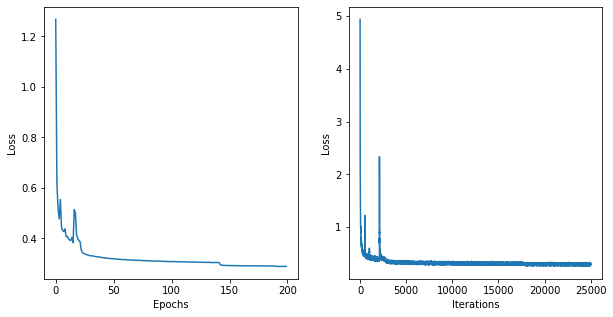

In [725]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [726]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [727]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/499 [00:00<?, ?it/s]

In [728]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/167 [00:00<?, ?it/s]

In [729]:
print(results_train.shape)
results_train.head()

(7983, 2)


,actual,prediction
0,553957,5-53399557
1,662608,6-62266008
2,396642,3996--6442
3,39881,339988-881
4,581773,588117-773


In [730]:
print(results_test.shape)
results_test.head()

(2661, 2)


,actual,prediction
0,1105002,1-1000--02
1,173198,1773311998
2,195279,1995522779
3,1098653,1009886553
4,x,xx--------


In [731]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [732]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,553957,5-53399557,553957
1,662608,6-62266008,662608
2,396642,3996--6442,396642
3,39881,339988-881,39881
4,581773,588117-773,581773


In [733]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,1105002,1-1000--02,11002
1,173198,1773311998,173198
2,195279,1995522779,195279
3,1098653,1009886553,1098653
4,x,xx--------,x


## 8. Evaluate the model

In [734]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,1105002,1-1000--02,11002
149,549888,54499888-8,54988
375,1114675,1-1-166775,111675
390,1088264,1008882664,108264
587,1244909,1244449909,124909
595,1444402,14-4444002,14402
627,871116,8871--1116,87116
648,1114782,1-1-177882,111782
767,155560,155--55660,15560
821,899891,899-999991,8991


In [735]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

5    19
6    18
4     3
Name: prediction_corrected, dtype: int64


In [736]:
mask = mistakes_df['prediction_corrected'].str.len() >= 0
mistakes_df[mask]

,actual,prediction,prediction_corrected
0,1105002,1-1000--02,11002
149,549888,54499888-8,54988
375,1114675,1-1-166775,111675
390,1088264,1008882664,108264
587,1244909,1244449909,124909
595,1444402,14-4444002,14402
627,871116,8871--1116,87116
648,1114782,1-1-177882,111782
767,155560,155--55660,15560
821,899891,899-999991,8991


In [737]:
# mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
# print(mistake_image_fp)
# mistake_image = Image.open(mistake_image_fp)
# plt.imshow(mistake_image)
# plt.show()

In [738]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

1.0
0.9849680571213829


In [739]:
torch.save(crnn, "crnn2.pt")